In [1]:
import numpy as np
from urllib import request
import gzip
import pickle
import os
import torch
from torch.nn.utils.rnn import pad_sequence
from torch import nn
from tqdm import tqdm, trange
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# # moves your model to train on your gpu if available else it uses your cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
!pip install wget

import wget, os, gzip, pickle, random, re, sys

IMDB_URL = 'http://dlvu.github.io/data/imdb.{}.pkl.gz'
IMDB_FILE = 'imdb.{}.pkl.gz'

PAD, START, END, UNK = '.pad', '.start', '.end', '.unk'

def load_imdb(final=False, val=5000, seed=0, voc=None, char=False):

    cst = 'char' if char else 'word'

    imdb_url = IMDB_URL.format(cst)
    imdb_file = IMDB_FILE.format(cst)

    if not os.path.exists(imdb_file):
        wget.download(imdb_url)

    with gzip.open(imdb_file) as file:
        sequences, labels, i2w, w2i = pickle.load(file)

    if voc is not None and voc < len(i2w):
        nw_sequences = {}

        i2w = i2w[:voc]
        w2i = {w: i for i, w in enumerate(i2w)}

        mx, unk = voc, w2i['.unk']
        for key, seqs in sequences.items():
            nw_sequences[key] = []
            for seq in seqs:
                seq = [s if s < mx else unk for s in seq]
                nw_sequences[key].append(seq)

        sequences = nw_sequences

    if final:
        return (sequences['train'], labels['train']), (sequences['test'], labels['test']), (i2w, w2i), 2

    # Make a validation split
    random.seed(seed)

    x_train, y_train = [], []
    x_val, y_val = [], []

    val_ind = set( random.sample(range(len(sequences['train'])), k=val) )
    for i, (s, l) in enumerate(zip(sequences['train'], labels['train'])):
        if i in val_ind:
            x_val.append(s)
            y_val.append(l)
        else:
            x_train.append(s)
            y_train.append(l)

    return (x_train, y_train), \
           (x_val, y_val), \
           (i2w, w2i), 2

In [3]:
(x_train, y_train), (x_val, y_val), (i2w, w2i), numcls = load_imdb(final=False)

In [4]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [5]:
x_train_pad = padding_(x_train,250)
x_val_pad = padding_(x_val,250)
y_train = np.asarray(y_train)
y_val = np.array(y_val)

In [6]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_val_pad), torch.from_numpy(y_val))

# dataloaders
batch_size = 128

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [7]:
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
#print('Sample input: \n', sample_x)
print('Sample input: ', sample_y.size())

Sample input size:  torch.Size([128, 250])
Sample input:  torch.Size([128])


In [8]:
class ELMAN(nn.Module):
    def __init__ ( self , insize = 300 , outsize = 300 , hsize = 300):
        super (). __init__ ()

        self.lin1 = nn.Linear(insize + hsize, hsize) 
        self.lin2 = nn.Linear(hsize, outsize)
        
    def forward ( self , x, hidden= None ):
        b, t, e = x.size()

        if hidden is None :
            hidden = torch.zeros(b, e, dtype =torch.float)
            
        outs = []
        for i in range (t):
            inp = torch.cat((x[:,i,:], hidden), dim = 1 )
            hidden = torch.tanh(self.lin1(inp))
            out = self.lin2(hidden)
            outs.append(out[:, None , :])
        
        return torch.cat(outs, dim = 1 ), hidden

In [9]:
class SEQ_ELMAN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        self.elman = ELMAN(300, 300, 300)
    
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):

        embedded = self.embedding(text)
        
        output, hidden = self.elman(embedded)

        output, _ = torch.max(output, dim = 1)

        output = self.linear2(output)
        
        return output

In [10]:
INPUT_DIM = len(w2i)
EMBEDDING_DIM = 300
HIDDEN_DIM = 300
OUTPUT_DIM = 2

model = SEQ_ELMAN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
model.to(device)
print(model)

SEQ_ELMAN(
  (embedding): Embedding(99430, 300)
  (elman): ELMAN(
    (lin1): Linear(in_features=600, out_features=300, bias=True)
    (lin2): Linear(in_features=300, out_features=300, bias=True)
  )
  (linear2): Linear(in_features=300, out_features=2, bias=True)
)


In [11]:
NUM_EPOCHS = 5
opt = torch.optim.Adam(model.parameters(), lr =0.01)

### Model Training

In [12]:
NUM_EPOCHS = 5
opt = torch.optim.Adam(model.parameters(), lr =0.01)

trainloss_epoch = []
valloss_epoch = []
trainacc_epoch = []
valacc_epoch = []

#trainloss_batch = []

for epoch in trange(NUM_EPOCHS):
    model.train()
    
    for sample_x, sample_y in iter(train_loader):
    
        sample_x = sample_x.to(device)
        sample_y = sample_y.to(device)

        opt.zero_grad()

        outputs = model(sample_x)
        loss = F.cross_entropy(outputs, sample_y)
        
        #trainloss_batch.append(loss.item())
        
        loss.backward()
        opt.step()
    
    with torch.no_grad():

        model.eval()  
        #trainloss = 0.0
        traincorrect = 0
        num = 0

        for sample_x, sample_y in iter(train_loader):
            
            sample_x = sample_x.to(device)
            sample_y = sample_y.to(device)
          
            outputs = model(sample_x)
            #loss = F.cross_entropy(outputs, sample_y, reduction='none').to(device)
            
            #num += loss.size(0)
            #trainloss += loss.sum().item()
            num = num + 1
            traincorrect += (outputs.argmax(dim=1) == sample_y).sum().item()
        
        #trainloss_epoch.append(trainloss/num)
        trainacc_epoch.append(traincorrect/num)
        
        #valloss = 0.0
        valcorrect = 0
        num = 0
        for sample_x, sample_y in iter(valid_loader):
       
            sample_x = sample_x.to(device)
            sample_y = sample_y.to(device)

            outputs = model(sample_x)
            #loss = F.cross_entropy(outputs, sample_y, reduction='none')
            
            #num += loss.size(0)
            #valloss += loss.sum().item()
            num = num + 1
            valcorrect += (outputs.argmax(dim=1) == sample_y).sum().item()
        
        #valloss_epoch.append(valloss/num)
        valacc_epoch.append(valcorrect/num)
        
        
pd.DataFrame(trainacc_epoch).to_csv('elman_trainacc_epoch.csv')
pd.DataFrame(valacc_epoch).to_csv('elman_valacc_epoch.csv')

 20%|██        | 1/5 [28:01<1:52:07, 1681.92s/it]


KeyboardInterrupt: 

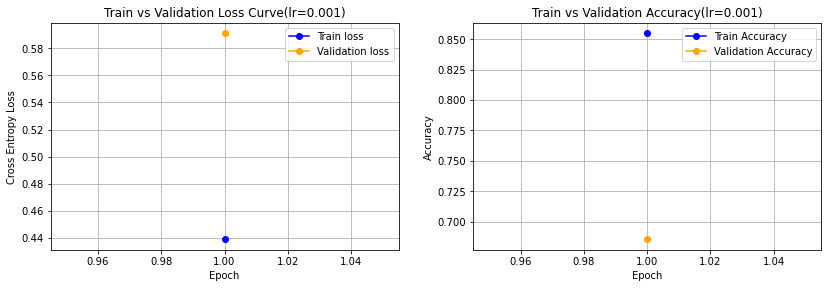

In [221]:
epoch_count = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(12,4.5))

plt.subplot(1, 2, 1)
#plt.plot(epoch_count, trainloss_epoch, '-o', color = 'blue', markevery = None, label='Train loss')
plt.plot(epoch_count, valloss_epoch,'-o', color = 'orange', markevery = None, label='Validation loss')
plt.legend()
plt.title("Train vs Validation Loss Curve(lr=0.001)")  
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Epoch")
plt.grid()


plt.subplot(1, 2, 2)
#plt.plot(epoch_count, trainacc_epoch, '-o', color = 'blue', markevery = None, label='Train Accuracy')
plt.plot(epoch_count, valacc_epoch, '-o', color = 'orange', markevery = None, label='Validation Accuracy')
plt.legend()
plt.title("Validation Accuracy(lr=0.001)")  
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.grid()

plt.tight_layout(pad = 2.5)

### Learning Rate Comparision

In [214]:
INPUT_DIM = len(w2i)
EMBEDDING_DIM = 300
HIDDEN_DIM = 300
OUTPUT_DIM = 2
curves = {}

for lr in tqdm([0.01, 0.001, 0.0001, 0.00000001]):

    model = SEQ_ELMAN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    curve = []

    for epoch in range(2):
        for sample_x, sample_y in iter(valid_loader): 
            sample_x = sample_x.to(device)
            sample_y = sample_y.to(device)

            # Training pass
            optimizer.zero_grad()

            # Forward pass
            output = model(sample_x)
           
            loss = F.cross_entropy(output, sample_y)

            curve.append(loss.item())

            #Backward pass
            loss.backward()
            optimizer.step()
            
            
        curves[lr] = curve

100%|██████████| 4/4 [1:26:25<00:00, 1296.36s/it]


Text(0.5, 1.0, 'Elman Peformance (batch_size=64, validation set, Adam optimizer)')

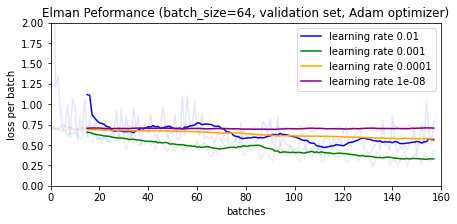

In [230]:
plt.figure(figsize=(7, 3))

for (lr, curve), color in zip(curves.items(), ['blue', 'green', 'orange', 'purple']):
    plt.plot(curve, color=color, alpha=0.1)

    k = 15
    smoothed, idx = [], []

    for to in range(k, len(curve)):
        fr = to - k
        smoothed.append(sum(curve[fr:to])/k)
        idx.append(to)

    plt.plot(idx, smoothed, color=color, label=f'learning rate {lr}')

plt.xlim(0, 160)
plt.ylim(0,2)
plt.legend()

plt.xlabel('batches')
plt.ylabel('loss per batch')
plt.title("Elman Peformance (batch_size=64, validation set, Adam optimizer)")